In this block we import all the needed python dependencies for basic data analysis. Notable ones:


*   pandas - allows csv files to be converted into a dataframe, allowing for quick iteration and data cleansing
*   warnings - catches depreciation warnings that overide the actual output

Then, using the pandas package, we read the csv file and drop all the uneeded data columns. Finally, by looping thruogh the enitre dataframe - all rows that containt non-english text is dropped based on the metadata within the 'lang' column.




In [ ]:
import os
import pandas as pd
import re
import string
from datetime import datetime
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


papers = pd.read_csv('FCovid_Jl20_Cleaned.csv', low_memory=False)
papers.head()


papers.drop(columns=['ID', 'ref_category_title', 'ref_url', 'pageid', 'verifiedby', 'title', 'published_date', 'country1', 'country2', 'country3', 'country4', 'article_source', 'ref_source', 'source_title', 'category'], axis=1)

for index, row in papers.iterrows():
  if row['lang'] == 'en':  
    continue
  else:
    papers.drop([index], inplace = True)

papers.head()



,ID,ref_category_title,ref_url,pageid,verifiedby,country,class,title,published_date,country1,country2,country3,country4,article_source,ref_source,source_title,content_text,category,lang,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,...,Unnamed: 853,Unnamed: 854,Unnamed: 855,Unnamed: 856,Unnamed: 857,Unnamed: 858,Unnamed: 859,Unnamed: 860,Unnamed: 861,Unnamed: 862,Unnamed: 863,Unnamed: 864,Unnamed: 865,Unnamed: 866,Unnamed: 867,Unnamed: 868,Unnamed: 869,Unnamed: 870,Unnamed: 871,Unnamed: 872,Unnamed: 873,Unnamed: 874,Unnamed: 875,Unnamed: 876,Unnamed: 877,Unnamed: 878,Unnamed: 879,Unnamed: 880,Unnamed: 881,Unnamed: 882,Unnamed: 883,Unnamed: 884,Unnamed: 885,Unnamed: 886,Unnamed: 887,Unnamed: 888,Unnamed: 889,Unnamed: 890,Unnamed: 891,Unnamed: 892
0,FC3145,FALSE: A photograph shared thousands of times ...,https://www.poynter.org/?ifcn_misinformation=a...,https://www.poynter.org/ifcn-covid-19-misinfor...,AFP,Africa,FALSE,A photograph shared thousands of times on Fac...,4/14/2020,Africa,NaN,NaN,NaN,https://factcheck.afp.com/picture-shows-work-m...,poynter,This picture shows the work of a make-up artis...,The post claims that the condition is caused b...,NaN,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FC1779,FALSE: Facebook posts shared thousands of time...,https://www.poynter.org/?ifcn_misinformation=f...,https://www.poynter.org/ifcn-covid-19-misinfor...,AFP,Argentina,FALSE,Facebook posts shared thousands of times accu...,5/30/2020,Argentina,NaN,NaN,NaN,https://factcheck.afp.com/empty-body-bags-were...,poynter,Empty body bags were used in protests and not ...,This South African Facebook post shared more t...,NaN,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,FC6686,misleading: Two photos which show human throat...,https://www.poynter.org/?ifcn_misinformation=t...,https://www.poynter.org/ifcn-covid-19-misinfor...,Chequeado,Argentina,misleading,Two photos which show human throats have been...,6/22/2020,Argentina,NaN,NaN,NaN,https://factcheck.afp.com/these-photos-have-ci...,poynter,These photos have circulated in reports before...,"""The post’s caption states in part: “When you ...",NaN,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,FC60,FALSE: Videos showing black people being attac...,https://www.poynter.org/?ifcn_misinformation=v...,https://www.poynter.org/ifcn-covid-19-misinfor...,AFP,"Asia, Africa",FALSE,Videos showing black people being attacked by...,4/19/2020,Asia,Africa,NaN,NaN,https://factcheck.afp.com/viral-videos-african...,poynter,Viral videos of Africans attacked in China wer...,The accompanying footage shows a black man pus...,NaN,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,FC51,False: A video of food packets deposited on a ...,https://www.poynter.org/?ifcn_misinformation=a...,https://www.poynter.org/ifcn-covid-19-misinfor...,AFP,Australia,FALSE,A video of food packets deposited on a street...,3/23/2020,Australia,NaN,NaN,NaN,https://factcheck.afp.com/video-shows-donation...,poynter,This video shows dona

Here we complete more data cleansing. Subsituting non-letter symbols with a null string thus deleting them from the to be analyzed text.
Other important processess:


*   Lower all capatalized letters
*   Print out cleaned dataset



In [ ]:
# Data cleaning
# Data Cleansing Begins

papers['content_text_processed'] = papers['content_text'].map(lambda x: re.sub('[,\\.!?]|', '', x))

papers['content_text_processed'] = papers['content_text_processed'].map(lambda x: x.lower())

papers['content_text_processed'].head()

0    the post claims that the condition is caused b...
1    this south african facebook post shared more t...
2    "the post’s caption states in part: “when you ...
3    the accompanying footage shows a black man pus...
4    the post’s caption reads: “in #turkey people h...
Name: content_text_processed, dtype: object

Importing gensim - the LDA model used to analzye the words and create topics


*   Importint simple_preprocess to complete data cleansing
*   Creating function to process each row of data
*  Segmenting each word and appending them into a list



In [ ]:
import gensim
from gensim.utils import simple_preprocess

def sentToWords(sentences):
    for sentences in sentences:
        yield (gensim.utils.simple_preprocess(str(sentences), deacc=True)) #deacc removes punctuation

data = papers.content_text_processed.values.tolist()
data_words = list(sentToWords(data))

print(data_words[:1][0][:30])

['the', 'post', 'claims', 'that', 'the', 'condition', 'is', 'caused', 'by', 'the', 'flour', 'semolina', 'or', 'semo', 'and', 'urges', 'people', 'to', 'avoid', 'eating', 'the', 'wheat', 'substance', 'found', 'in', 'pasta', 'and', 'couscous', 'the', 'accompanying']


Building bigram and trigram models - though bigram models are the only ones used


*   Bigrams are common phrases that are made up of two seperate words (Ex: Thank you, evidence of, etc) - can improve readibility later on
*   Two ways to generate bigrams - the second manner is faster



In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

#faster way
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

NLTK package includes stopwords from a multitude of langauges
Stopwords are filler or useless words winthin a language that don't mean anything but simply help with syntax and grammar (EX: a, the, who, why, etc)


*   download the english stopwords
*   then remove all the stopwords from the list
*   define the lemmatization() function to lemmatize all the words - using lemmatization instead of stemming because it is more complex - factors in part of speech (noun, adverb, adjective, ect) and other points 



In [ ]:
# Remove Stopwords, Make Bigrams and Lemmatize
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def remove_stopwords(texts):
    return  [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://aspacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Importing Spacy - spacy is an open-source library that providees the NLP (natural language processesing tool) This allows us to tokenize the words and eventually tag and count the number of appearances of important words



*   Using the medium english model - the nlp is passed into the lemmatization() function to lemmatize all the previous data which is passed into the list data_lemmatized
*   results are then printed



In [ ]:
import spacy #for
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])


[['claim', 'condition', 'cause', 'flour', 'semolina', 'urge', 'people', 'avoid', 'eat', 'wheat', 'substance', 'find', 'pasta', 'couscous', 'accompany', 'photo', 'show', 'person', 'hand', 'arm', 'cover', 'red', 'blister', 'graphic', 'content', 'show', 'hide', 'fact', 'check', 'image', 'search', 'trace', 'photograph', 'account', 'base', 'make', 'artist', 'work', 'earlier', 'read', 'caption', 'show', 'gruesome', 'picture', 'fake', 'real', 'special', 'effect', 'makeup', 'contact', 'fact', 'check', 'confirm', 'show', 'work', 'reject', 'post', 'claim', 'show', 'disease', 'fake', 'create', 'effect', 'use', 'type', 'wax', 'fake', 'blood', 'effect', 'create', 'call', 'fear', 'small', 'hole', 'bump', 'person', 'effect', 'hand', 'sister', 'say', 'page', 'feature', 'image', 'hand', 'various', 'angle', 'find', 'furthermore', 'medical', 'expert', 'tell', 'fact', 'check', 'eat', 'semolina', 'can', 'cause', 'kind', 'reaction', 'show', 'picture', 'image', 'accurate', 'say', 'clinical', 'occasionally', 

Creating the data structures needed to run the Gensim LDA from the all the previous steps. 


*   We need an id2word (or a dictionary that maps the numerical id assigned to a corresponding word)
*   corpus - List that keep tracks of the frequency of each word



In [ ]:
import gensim.corpora as corpora

#New Dictionary
id2word = corpora.Dictionary(data_lemmatized)

#New Corpus
texts = data_lemmatized

#Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 2), (19, 1), (20, 4), (21, 4), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 4), (29, 1), (30, 1), (31, 2), (32, 1), (33, 1), (34, 1), (35, 2), (36, 2), (37, 1), (38, 1), (39, 1), (40, 1), (41, 3), (42, 4), (43, 1), (44, 1), (45, 1), (46, 4), (47, 3), (48, 1), (49, 1), (50, 2), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 3), (59, 1), (60, 1), (61, 1), (62, 1), (63, 4), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 2), (78, 2), (79, 1), (80, 2), (81, 2), (82, 1), (83, 2), (84, 1), (85, 1), (86, 1), (87, 2), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 2), (95, 1), (96, 2), (97, 1), (98, 7), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1)

Finding baseline model - running it with num_topics = 10. Notice both id2word corpus are based into the model

In [ ]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

Printing the Results of the baseline model

In [ ]:
from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


[(0,
  '0.065*"vaccine" + 0.027*"fact" + 0.021*"test" + 0.020*"medium" + '
  '0.020*"drug" + 0.017*"claim" + 0.015*"check" + 0.013*"post" + 0.012*"find" '
  '+ 0.012*"public"'),
 (1,
  '0.036*"message" + 0.026*"claim" + 0.024*"coronavirus" + 0.021*"drink" + '
  '0.017*"cure" + 0.016*"prevent" + 0.015*"information" + 0.014*"check" + '
  '0.013*"water" + 0.013*"social"'),
 (2,
  '0.021*"medium" + 0.019*"coronavirus" + 0.017*"post" + 0.017*"claim" + '
  '0.016*"fact" + 0.013*"check" + 0.012*"social" + 0.011*"report" + '
  '0.011*"people" + 0.010*"also"'),
 (3,
  '0.059*"patient" + 0.034*"hospital" + 0.031*"coronavirus" + 0.020*"treat" + '
  '0.018*"die" + 0.018*"test" + 0.017*"doctor" + 0.016*"covid" + 0.016*"death" '
  '+ 0.015*"say"'),
 (4,
  '0.048*"coronavirus" + 0.034*"rumor" + 0.027*"virus" + 0.020*"coincide" + '
  '0.020*"violence" + 0.013*"medium" + 0.013*"people" + 0.013*"claim" + '
  '0.012*"month" + 0.012*"spread"'),
 (5,
  '0.024*"say" + 0.013*"may" + 0.011*"would" + 0.011*"tr

Printing the Coherence Score of the baseline Model

In [ ]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4453381437437279


Defining a function to train an LDA model based on different hyperparameters - in this case soley K_topics will change.

In [ ]:
#tuning Hyperparemeters - (Number of Topics (k), Dirichlet hyperparameter alpha (Document-Topic Density), Word-Topic Density) - defining function to increase eficiney

def compute_coherence_values(corpus, dictionary, k):
  lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=k, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)
  coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')

  return coherence_model_lda.get_coherence()

    

Setting up the loop that will use the previos function compute_coherence_values() to find the optimal number of k topics


*   First definie the range of topics (in this case 2 - 12 topics)
*   Second, using  two for loops - 1 to loop through 2-12 topics, 2 to train the model 5 different times with same k_topics to make verify the coherence scores are not an outlier 
*   By Averaging the 5 coherence scores - we eliminate outlier scores and allow for a more accurate representation of the coherence of a certain value of k_topics 



In [ ]:
import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 13
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = int(len(corpus))
corpus_sets = [gensim.utils.ClippedCorpus(corpus, num_of_docs*0.75), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
averageDict = {}
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=55)
    
    for k in topics_range:
      
      model_results['Topics'].append(k)
      for i in range(0, 5):
        # iterate through alpha values
        # get the coherence score for the given parameters
        cv = compute_coherence_values(corpus, id2word, k)
        # Save the model results
        if k in averageDict:
          averageDict[k].append(cv)
        else:
          averageDict[k] = [cv]
            
        pbar.update(1)
    
    pbar.close()

for averageList in averageDict.values():
  model_results['Coherence'].append(sum(averageList) / len(averageList))

100%|██████████| 55/55 [53:27<00:00, 58.32s/it]


The data is then printed out

In [ ]:
#Printing Results
print(averageDict)
print(model_results['Topics'])
print(model_results['Coherence'])

maxCoherence = max(model_results['Coherence'])
index1 = model_results['Coherence'].index(maxCoherence)
numTopics = model_results['Topics'][index1]
print('Optimal Topcis: ' + str(numTopics))

{2: [0.3250034090601571, 0.3250034090601571, 0.3250034090601571, 0.3250034090601571, 0.325003409060157], 3: [0.39256822896047305, 0.39449415727093085, 0.39449415727093085, 0.3868746674247648, 0.3868746674247648], 4: [0.3674668196300343, 0.374498963118074, 0.3807357319124574, 0.374498963118074, 0.3674668196300343], 5: [0.4415551699403766, 0.4415551699403766, 0.45081054213105415, 0.44232006521217937, 0.44499387445291044], 6: [0.4339483560833834, 0.43919022556179144, 0.43769901219481366, 0.43769901219481366, 0.4324571427164056], 7: [0.4365645800746229, 0.4322903702638882, 0.436564580074623, 0.43656458007462307, 0.436564580074623], 8: [0.45172277801645344, 0.45191262506023566, 0.44284232365121373, 0.4561371411668418, 0.45594729412305957], 9: [0.4975999311101213, 0.49309870165775166, 0.49127763005444547, 0.49157953770765583, 0.49157953770765583], 10: [0.4465984075366386, 0.44695625580108855, 0.44566156038950905, 0.44695625580108855, 0.44695625580108855], 11: [0.46291496617881267, 0.46692512

Using the elbow method, the averaged coherence scores are graphed to visually represent what the optimal value is. Clearly when k = 9 is the optimal value

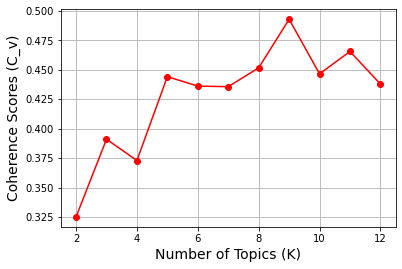

In [ ]:
# plotting results

import matplotlib.pyplot as plt

plt.plot(model_results['Topics'], model_results['Coherence'], color='red', marker = 'o')
plt.ylabel('Coherence Scores (C_v)', fontsize=14)
plt.xlabel('Number of Topics (K)', fontsize=14)
plt.grid(True)
plt.show()





Final model with optimal hyperparameters are trained

In [ ]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=numTopics, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.01,
                                           eta=0.9)

lda_model.save(temp_file)



Using the pyLDAvis package to display the results of the LDA in a readable and accessible manner 

In [ ]:
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.269151 -0.025681       1        1  47.715073
1     -0.257524 -0.092930       2        1  33.845094
0     -0.198846  0.144855       3        1  14.990469
3      0.111013 -0.101172       4        1   2.442186
4      0.114655  0.016668       5        1   0.800882
6      0.125227  0.014832       6        1   0.082648
7      0.124979  0.015446       7        1   0.072690
8      0.125025  0.013654       8        1   0.037998
5      0.124622  0.014327       9        1   0.012959, topic_info=             Term         Freq        Total Category  logprob  loglift
360         video  3122.000000  3122.000000  Default  30.0000  30.0000
548         virus  4386.000000  4386.000000  Default  29.0000  29.0000
2855        trump  1132.000000  1132.000000  Default  28.0000  28.0000
677       prevent   737.000000   737.000000  Default  27.0000  27.0000
456          kill  1864.000000  1864.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
306       outrage     0.011207    11.848876   Topic9  -8.9527   1.9877
9203  inauthentic     0.014146    46.229739   Topic9  -8.7197   0.8592
1463     overseas     0.012771    35.861248   Topic9  -8.8220   1.0109
6345       parade     0.011508    22.896612   Topic9  -8.9262   1.3554
5092         wrap     0.011438    23.234847   Topic9  -8.9322   1.3347

[527 rows x 6 columns], token_table=       Topic      Freq            Term
term                                  
13991      1  0.577818    acquaintance
13991      2  0.144455    acquaintance
13991      3  0.144455    acquaintance
1787       1  0.050339  administration
1787       2  0.020728  administration
...      ...       ...             ...
5092       4  0.043039            wrap
5210       1  0.037269            zinc
5210       2  0.167712            zinc
5210       3  0.018635            zinc
5210       4  0.782657            zinc

[1695 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 4, 5, 7, 8, 9, 6])

In [ ]:
!pip install gensim

In [ ]:
!pip install --upgrade gensim

Requirement already up-to-date: gensim in /usr/local/lib/python3.7/dist-packages (4.0.1)


In [ ]:
!pip install python-Levenshtein

In [ ]:
!pip install pyldavis

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_md

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')
